In [1]:
# SETTINGS
h5_filename = "ffindex_fiqa_tct.h5"
dataset_description = "FiQA"
lexical_retrieval_description = "TCT-ColBERT"

In [2]:
import glob

profile_dir = f"profiles/{h5_filename}/"

# Find all reranking profiles
profiles = glob.glob(profile_dir + "**/rerank.prof", recursive=True)

# Sort the profiles by name
profiles.sort()

# Print the list of files per line
for profile in profiles:
    print(profile)

profiles/ffindex_fiqa_tct.h5/cpu_k1000_!mem/rerank.prof
profiles/ffindex_fiqa_tct.h5/cpu_k1000_mem/rerank.prof
profiles/ffindex_fiqa_tct.h5/cpu_k5000_mem/rerank.prof
profiles/ffindex_fiqa_tct.h5/cuda_k1000_!mem/rerank.prof
profiles/ffindex_fiqa_tct.h5/cuda_k1000_mem/rerank.prof
profiles/ffindex_fiqa_tct.h5/cuda_k5000_mem/rerank.prof


In [3]:
import pstats

profile_data = {}
for profile in profiles:
    # Get the unique part of the title, and rewrite as follows:
    # - cpu_ --> CPU, cuda_ --> GPU, gpu_ --> GPU
    # - kX_ --> k=X
    # - _mem --> (memory), _!mem --> (disk)
    title = profile.split(profile_dir)[1].split("/rerank.prof")[0]
    title = title.replace("cpu_", "CPU, ")
    title = title.replace("gpu_", "GPU, ")
    title = title.replace("cuda_", "GPU, ")
    title = title.replace("k", "k=")
    title = title.replace("_mem", ", mem")
    title = title.replace("_!mem", ", disk")
    print(title)

    ps = pstats.Stats()
    ps.add(profile)
    ps.sort_stats("cumtime")

    # Get the total runtime of the profile
    total_time = round(ps.total_tt, 1)
    print("\tRuntime total:", total_time)

    # Get the re-ranking runtime 
    reranking_time = round(ps.stats["/usr/local/lib/python3.10/dist-packages/fast_forward/index/__init__.py", 363, "__call__"][3], 1)
    print("\tRuntime re-ranking:", reranking_time)

    # Get the runtime (and re-ranking %) of the 'encode_queries' method
    q_encoder_time = round(ps.stats["/usr/local/lib/python3.10/dist-packages/fast_forward/index/__init__.py", 50, "encode_queries"][3], 1)
    q_encoder_p = round(q_encoder_time / reranking_time * 100, 1)
    print("\tRe-ranking runtime % on 'encode_queries':", q_encoder_p)

    # Get the runtime (and re-ranking %) of the 'lookup_documents' method
    # Note that the class differs between memory and disk
    try:
        d_stats = ps.stats["/usr/local/lib/python3.10/dist-packages/fast_forward/index/memory.py", 125, "_get_vectors"]
    except KeyError:
        d_stats = ps.stats["/usr/local/lib/python3.10/dist-packages/fast_forward/index/disk.py", 222, "_get_vectors"]
    d_lookup_time = round(d_stats[3], 1)
    d_lookup_p = round(d_lookup_time / reranking_time * 100, 1)
    print("\tRe-ranking runtime % on 'lookup_documents':", d_lookup_p)

    # Get the runtime (and re-ranking %) of the 'compute_scores' method
    # Note that this only considers the recursive call
    compute_scores_time = round(ps.stats["/usr/local/lib/python3.10/dist-packages/fast_forward/index/__init__.py", 233, "_compute_scores"][2], 1)
    compute_scores_p = round(compute_scores_time / reranking_time * 100, 1)
    print("\tRe-ranking runtime % on 'compute_scores':", compute_scores_p)

    other_time = round(reranking_time - q_encoder_time - d_lookup_time - compute_scores_time, 1)
    other_p = round(other_time / reranking_time * 100, 1)
    print("\tRe-ranking runtime % on 'other':", other_p)

    # Save a dict of total_time, q_encoder_time and q_encoder_percentage
    profile_data[title] = {
        "total_time": total_time,
        "reranking_time": reranking_time,
        "q_encoder_time": q_encoder_time,
        "q_encoder_p": q_encoder_p,
        "d_lookup_time": d_lookup_time,
        "d_lookup_p": d_lookup_p,
        "compute_scores_time": compute_scores_time,
        "compute_scores_p": compute_scores_p,
        "other_time": other_time,
        "other_p": other_p
    }

CPU, k=1000, disk
	Runtime total: 122.6
	Runtime re-ranking: 97.6
	Re-ranking runtime % on 'encode_queries': 74.8
	Re-ranking runtime % on 'lookup_documents': 8.8
	Re-ranking runtime % on 'compute_scores': 8.0
	Re-ranking runtime % on 'other': 8.4
CPU, k=1000, mem
	Runtime total: 112.9
	Runtime re-ranking: 87.6
	Re-ranking runtime % on 'encode_queries': 80.1
	Re-ranking runtime % on 'lookup_documents': 0.5
	Re-ranking runtime % on 'compute_scores': 9.9
	Re-ranking runtime % on 'other': 9.5
CPU, k=5000, mem
	Runtime total: 114.1
	Runtime re-ranking: 88.5
	Re-ranking runtime % on 'encode_queries': 79.1
	Re-ranking runtime % on 'lookup_documents': 0.3
	Re-ranking runtime % on 'compute_scores': 10.8
	Re-ranking runtime % on 'other': 9.7
GPU, k=1000, disk
	Runtime total: 48.1
	Runtime re-ranking: 24.4
	Re-ranking runtime % on 'encode_queries': 5.7
	Re-ranking runtime % on 'lookup_documents': 32.0
	Re-ranking runtime % on 'compute_scores': 23.8
	Re-ranking runtime % on 'other': 38.5
GPU, k=1

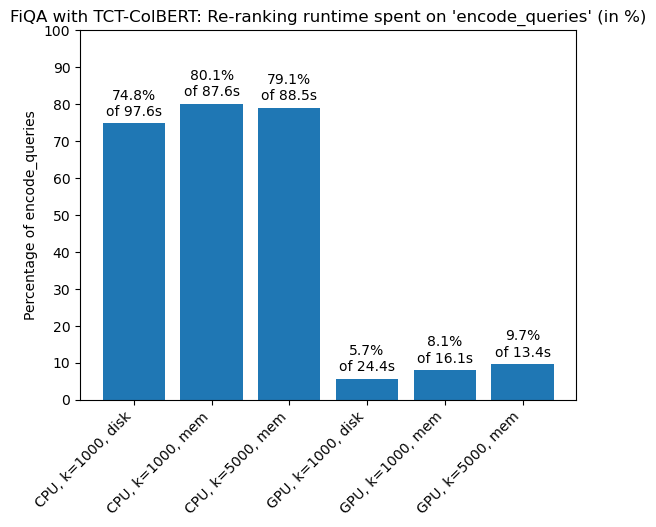

In [4]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()
ax.set_title(f"{dataset_description} with {lexical_retrieval_description}: Re-ranking runtime spent on 'encode_queries' (in %)")

# Create a bar chart
ax.bar(
    range(len(profile_data)),
    [data["q_encoder_p"] for data in profile_data.values()],
)
# Show percentage above each bar
for i, data in enumerate(profile_data.values()):
    ax.text(
        i,
        data["q_encoder_p"] + 2,
        f"{data['q_encoder_p']}%\nof {data['reranking_time']}s",
        ha="center",
    )

# Set the x-axis
ax.set_xticks(range(len(profile_data)))
ax.set_xticklabels(profile_data.keys(), rotation=45, ha="right")

# Set the y-axis
ax.set_yticks(range(0, 101, 10))
ax.set_ylabel("Percentage of encode_queries")


plt.show()

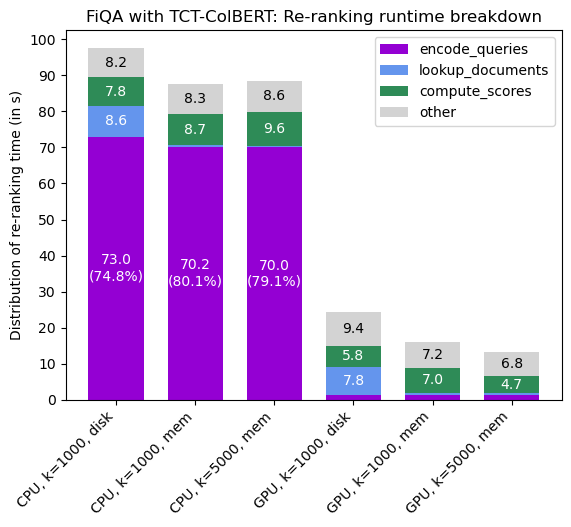

In [5]:
# Categorize the data into 4 bins: q_encoder, d_lookup, compute_scores, other
# Create a bar plot of the 4 bins, with the reranking time as the height
# Show the percentage of the total reranking time in the middle of each bar

# Create a figure and axis
fig, ax = plt.subplots()
ax.set_title(f"{dataset_description} with {lexical_retrieval_description}: Re-ranking runtime breakdown")

# Create a bar chart
bar_width = 0.7
x = range(len(profile_data))
data = list(profile_data.values())
ax.bar(
    x,
    [data["q_encoder_time"] for data in profile_data.values()],
    bar_width,
    label="encode_queries",
    color="darkviolet",
)
ax.bar(
    x,
    [data["d_lookup_time"] for data in profile_data.values()],
    bar_width,
    label="lookup_documents",
    color="cornflowerblue",
    bottom=[data["q_encoder_time"] for data in profile_data.values()],
)
ax.bar(
    x,
    [data["compute_scores_time"] for data in profile_data.values()],
    bar_width,
    label="compute_scores",
    color="seagreen",
    bottom=[data["q_encoder_time"] + data["d_lookup_time"] for data in profile_data.values()],
)
ax.bar(
    x,
    [data["other_time"] for data in profile_data.values()],
    bar_width,
    label="other",
    color="lightgrey",
    bottom=[data["q_encoder_time"] + data["d_lookup_time"] + data["compute_scores_time"] for data in profile_data.values()],
)

# Show amount of seconds for each segment in its middle, except for values < 3
for i, data in enumerate(profile_data.values()):
    if data["q_encoder_time"] > 3:
        ax.text(
            i,
            data["q_encoder_time"] / 2,
            f"{data['q_encoder_time']}\n({data['q_encoder_p']}%)",
            ha="center",
            va="center",
            color="white",
        )
    if data["d_lookup_time"] > 3:
        ax.text(
            i,
            data["q_encoder_time"] + data["d_lookup_time"] / 2,
            f"{data['d_lookup_time']}",
            ha="center",
            va="center",
            color="white",
        )
    if data["compute_scores_time"] > 3:
        ax.text(
            i,
            data["q_encoder_time"] + data["d_lookup_time"] + data["compute_scores_time"] / 2,
            f"{data['compute_scores_time']}",
            ha="center",
            va="center",
            color="white",
        )
    if data["other_time"] > 3:
        ax.text(
            i,
            data["q_encoder_time"] + data["d_lookup_time"] + data["compute_scores_time"] + data["other_time"] / 2,
            f"{data['other_time']}",
            ha="center",
            va="center",
            color="black",
        )

# Set the x-axis
ax.set_xticks(range(len(profile_data)))
ax.set_xticklabels(profile_data.keys(), rotation=45, ha="right")

# Set the y-axis
ax.set_yticks(range(0, 101, 10))
ax.set_ylabel("Distribution of re-ranking time (in s)")
ax.legend()

# Give it a transparent background
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.show()